## Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import pickle
import os
import anndata as ad
import seaborn as sns
from src import utils
from sklearn.decomposition import NMF
from scipy.stats import pearsonr
import random

utils.plot_style()
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)
os.makedirs('plots/', exist_ok=True)

In [2]:
path = 'results/final/'
results = pickle.load(open(os.path.join(path, 'latents.pkl'), 'rb'))
other = pickle.load(open(os.path.join(path, 'other.pkl'), 'rb'))
data = pd.read_feather('../../data/application/data_preprocessed.feather')
bento_data = ad.read_h5ad('../../data/application/bento/seqfish+_processed.h5ad')

data['gene_id'], _ = pd.factorize(data['gene'].astype(str))
data['cell_id'], _ = pd.factorize(data['cell'].astype(str))
data_rescaled = utils.rescale_cells(data)

gene_count = (data.groupby(['gene']).size().to_frame('count')
    .sort_values(by='count').reset_index())
filtered_genes = (gene_count.query('count > ({} * 30)'
    .format(data.cell.unique().shape[0])).gene.values)

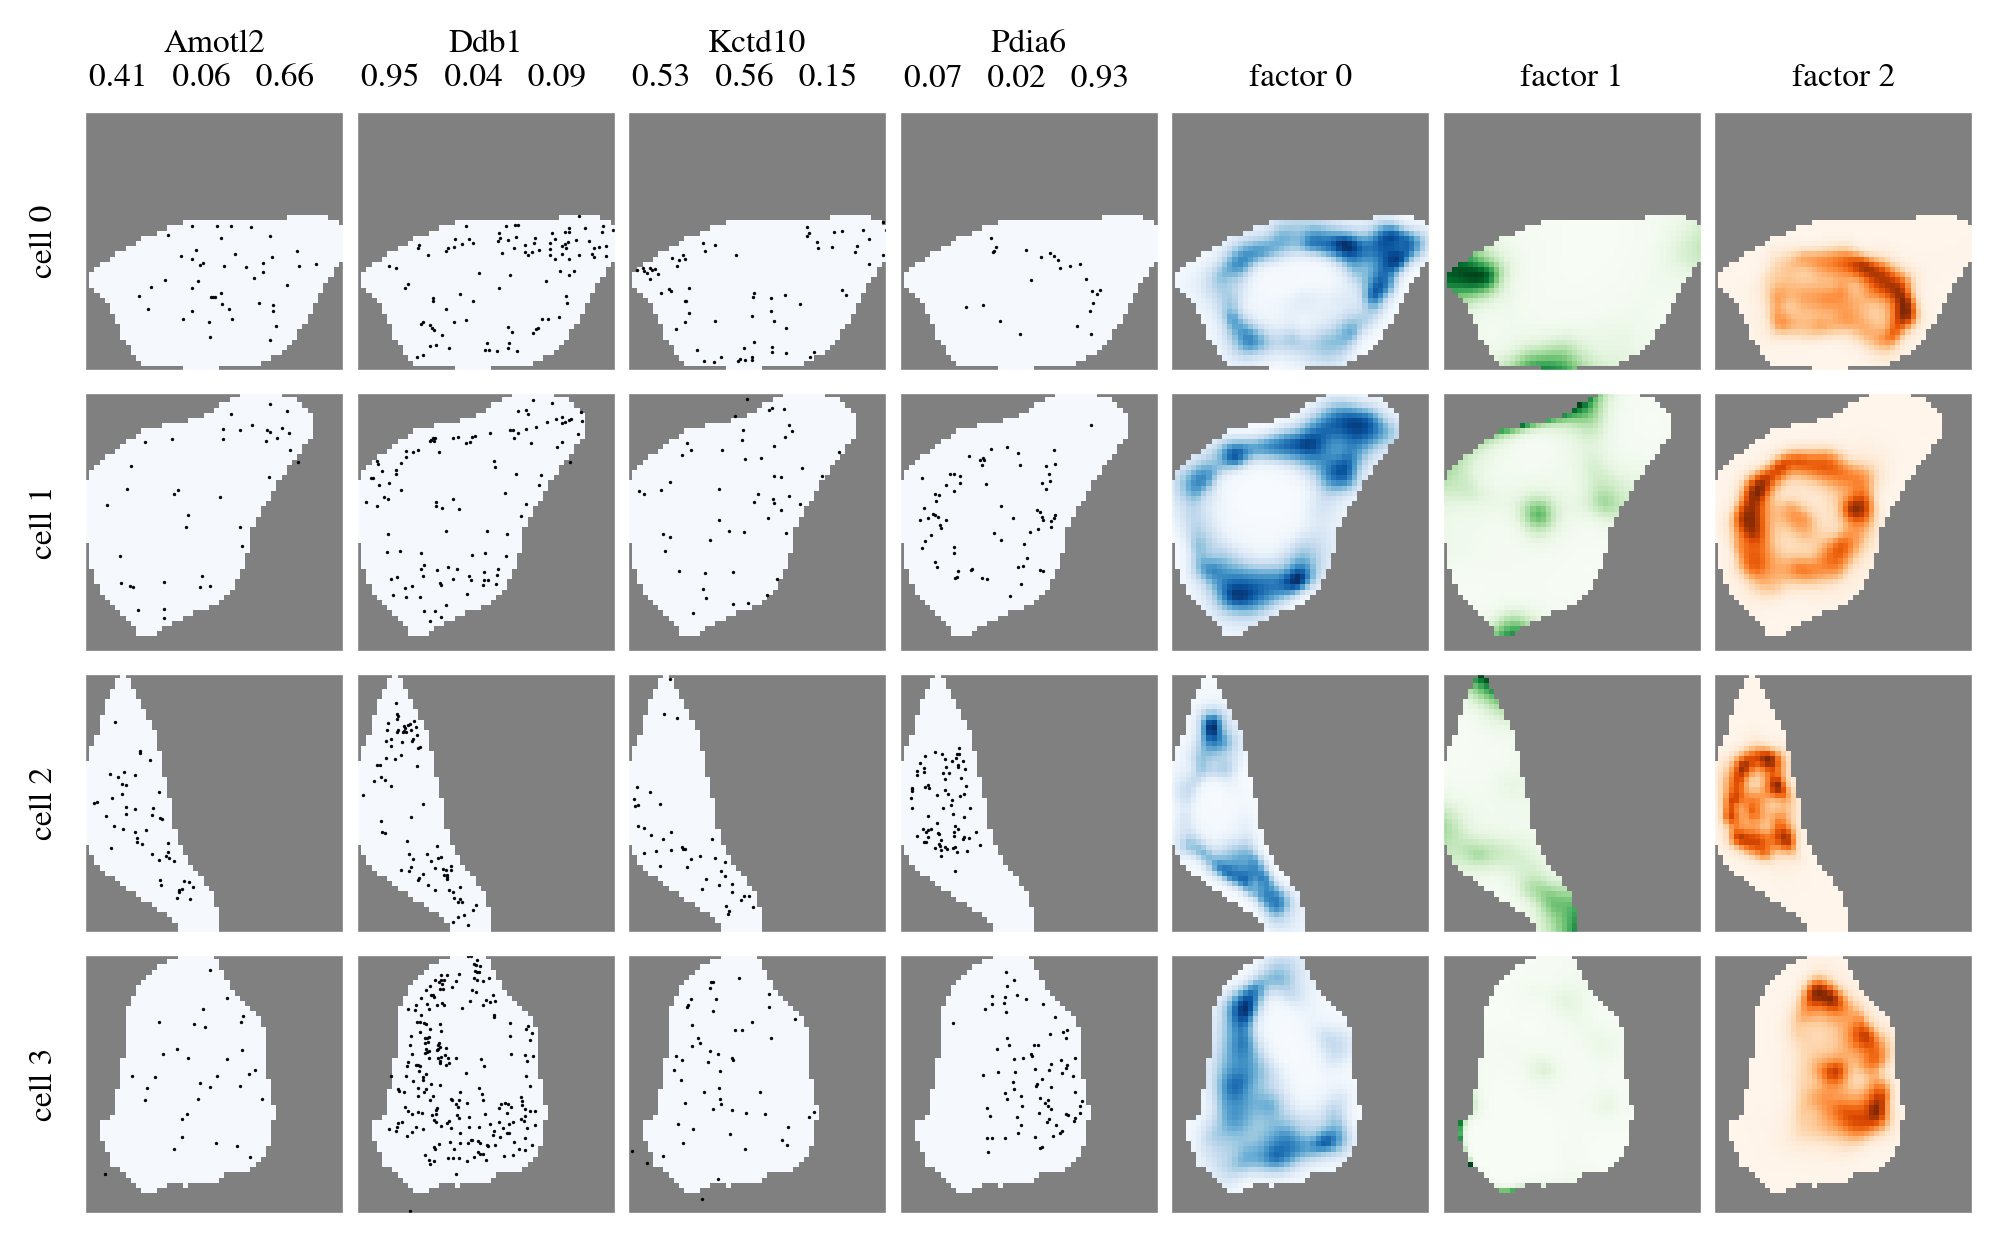

In [3]:
fig, axs = plt.subplots(4, 7, figsize=(6.5, 4), dpi=300)

genes = ['Amotl2', 'Ddb1', 'Kctd10', 'Pdia6']

w = results['w']
w /= w.max(dim=0)[0].view(1, w.shape[1])

for cell in range(4):
    for j, gene in enumerate(genes): 
        cmap = mpl.cm.get_cmap('Blues').copy()
        cmap.set_under(color='grey')
        ax=axs[cell, j]
        gene_cell_data = data_rescaled[(data_rescaled.gene==gene) & (data_rescaled.cell==cell)]
        ax.matshow(other['masks'][cell], origin='lower', cmap=cmap, vmin=1e-6, vmax=100)
        ax.scatter(gene_cell_data.x * 50, gene_cell_data.y * 50, s=0.5, c='black', linewidths=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ind = np.where(other['genes'].to_numpy() == gene)
        weights = w[ind].flatten()
        axs[0, j].set_title(gene + '\n' + ''.join([str(round(weights[i].item(), 2)) + '   ' for i in range(3)]))
        axs[cell, 0].set_ylabel('cell {}'.format(cell))
        

    for factor in range(3):
        cmap = mpl.cm.get_cmap(['Blues', 'Greens', 'Oranges'][factor]).copy()
        cmap.set_under(color='grey')
        z = results['z'][cell, factor]
        z = torch.nan_to_num(z, 0)
        z /= z.max()
        im = axs[cell, factor+4].matshow(z, origin='lower', cmap=cmap, vmin=1e-6)
        axs[0, factor+4].set_title('factor {}'.format(factor))
        #plt.colorbar(im, ax=axs[cell, factor+4], fraction=0.046, pad=0.04, location='bottom')

for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad=0.1)
plt.savefig('plots/molecules_factors.svg')


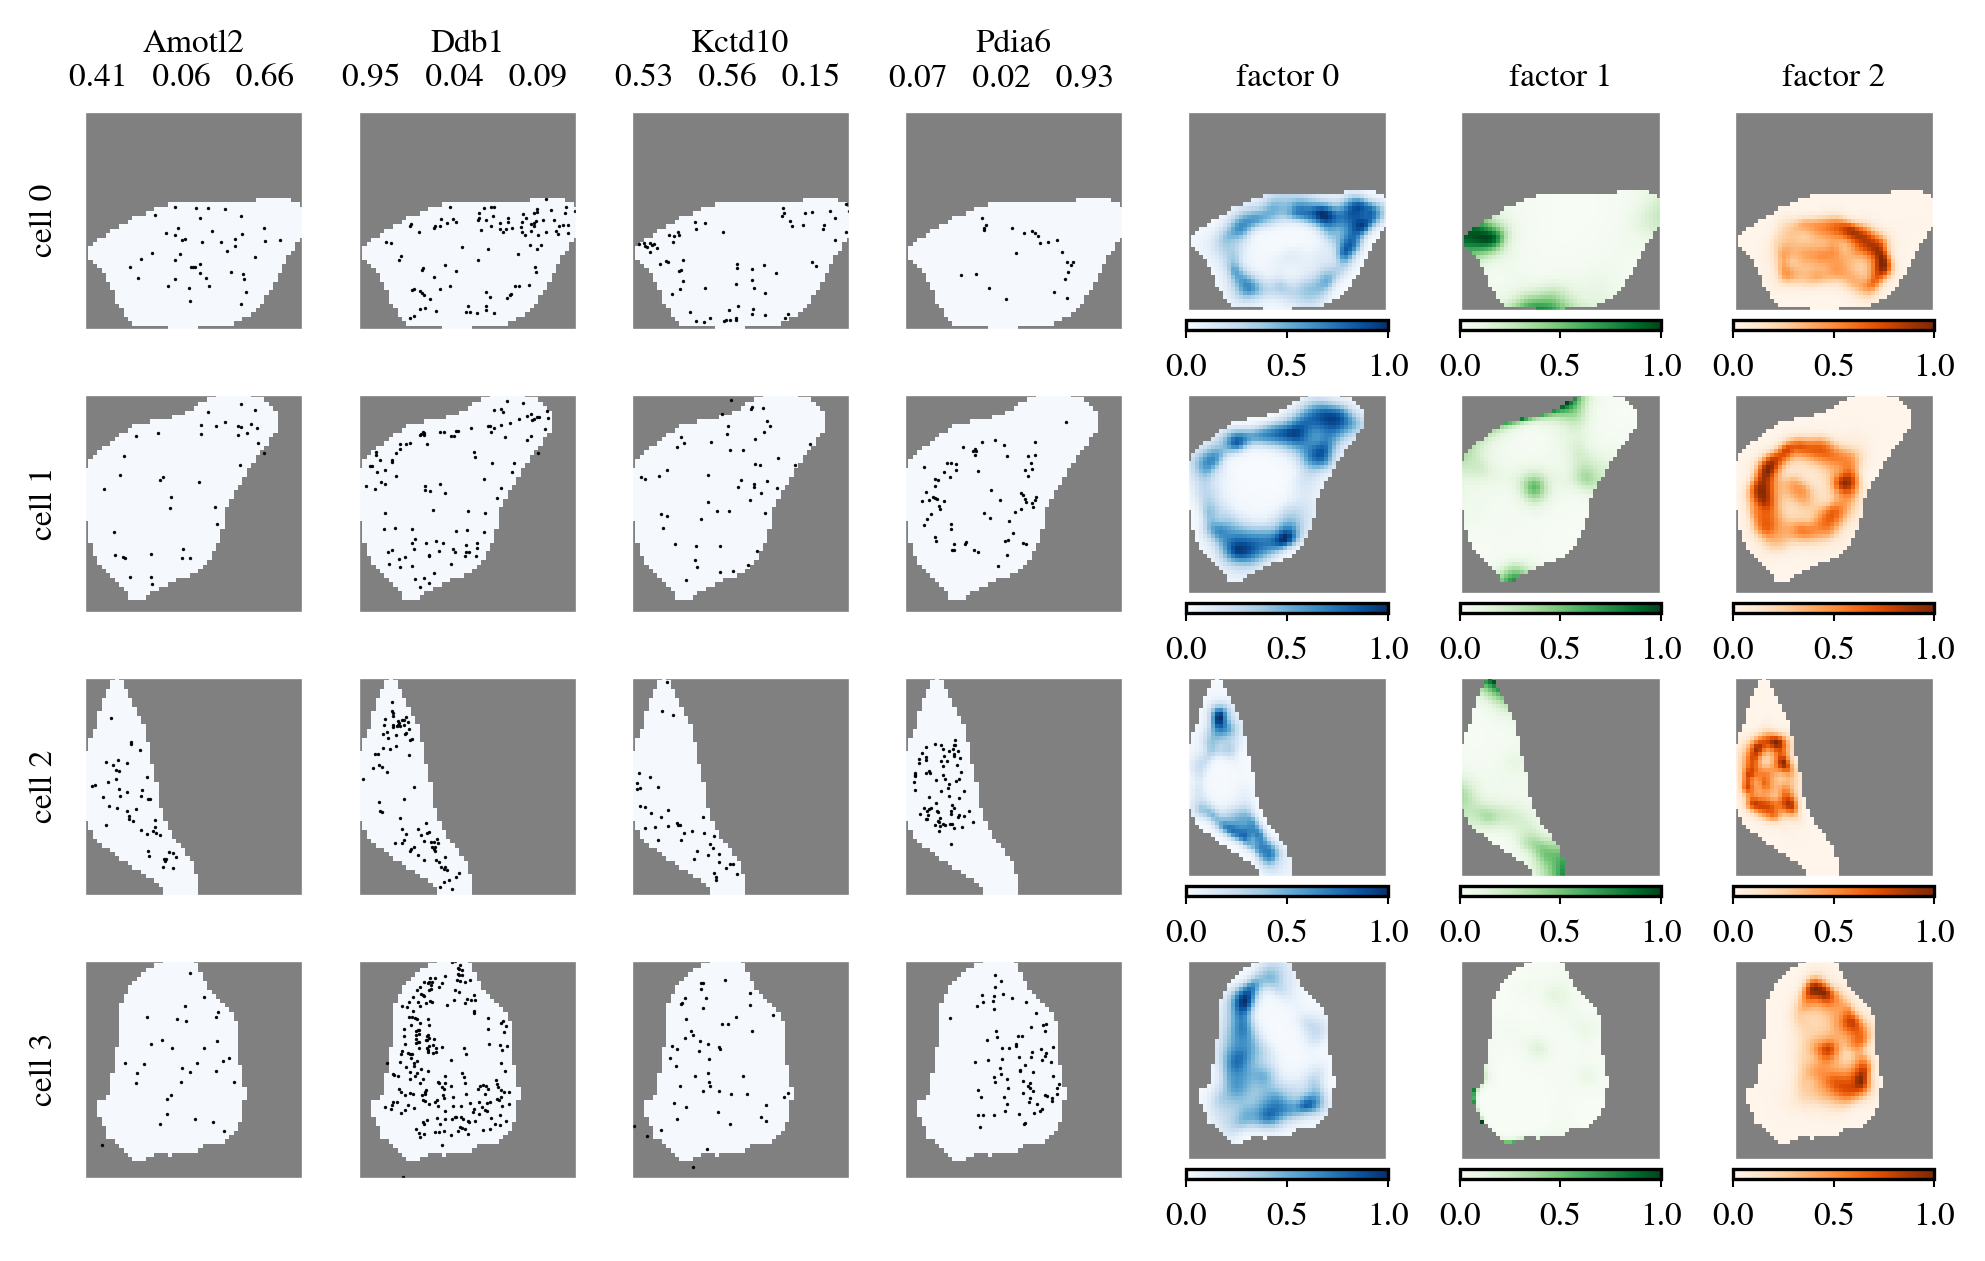

In [4]:
fig, axs = plt.subplots(4, 7, figsize=(6.5, 4), dpi=300)

genes = ['Amotl2', 'Ddb1', 'Kctd10', 'Pdia6']

w = results['w']
w /= w.max(dim=0)[0].view(1, w.shape[1])

for cell in range(4):
    for j, gene in enumerate(genes): 
        cmap = mpl.cm.get_cmap('Blues').copy()
        cmap.set_under(color='grey')
        ax=axs[cell, j]
        gene_cell_data = data_rescaled[(data_rescaled.gene==gene) & (data_rescaled.cell==cell)]
        ax.matshow(other['masks'][cell], origin='lower', cmap=cmap, vmin=1e-6, vmax=100)
        ax.scatter(gene_cell_data.x * 50, gene_cell_data.y * 50, s=0.5, c='black', linewidths=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ind = np.where(other['genes'].to_numpy() == gene)
        weights = w[ind].flatten()
        axs[0, j].set_title(gene + '\n' + ''.join([str(round(weights[i].item(), 2)) + '   ' for i in range(3)]))
        axs[cell, 0].set_ylabel('cell {}'.format(cell))
        

    for factor in range(3):
        cmap = mpl.cm.get_cmap(['Blues', 'Greens', 'Oranges'][factor]).copy()
        cmap.set_under(color='grey')
        z = results['z'][cell, factor]
        z = torch.nan_to_num(z, 0)
        z /= z.max()
        im = axs[cell, factor+4].matshow(z, origin='lower', cmap=cmap, vmin=1e-6)
        axs[0, factor+4].set_title('factor {}'.format(factor))
        cbar = plt.colorbar(im, ax=axs[cell, factor+4], fraction=0.046, pad=0.04, location='bottom')
        cbar.ax.set_xticks([0., 0.5, 1.])

for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad=0.1)
plt.savefig('plots/molecules_factors_colorbar.svg')

## Weights

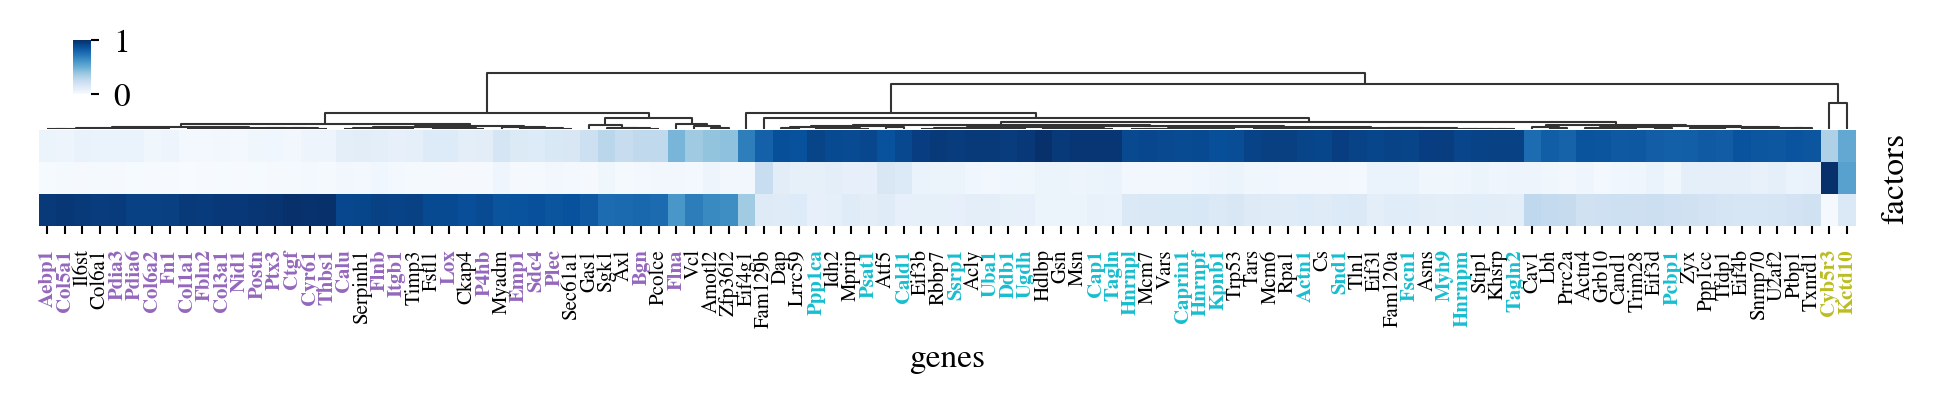

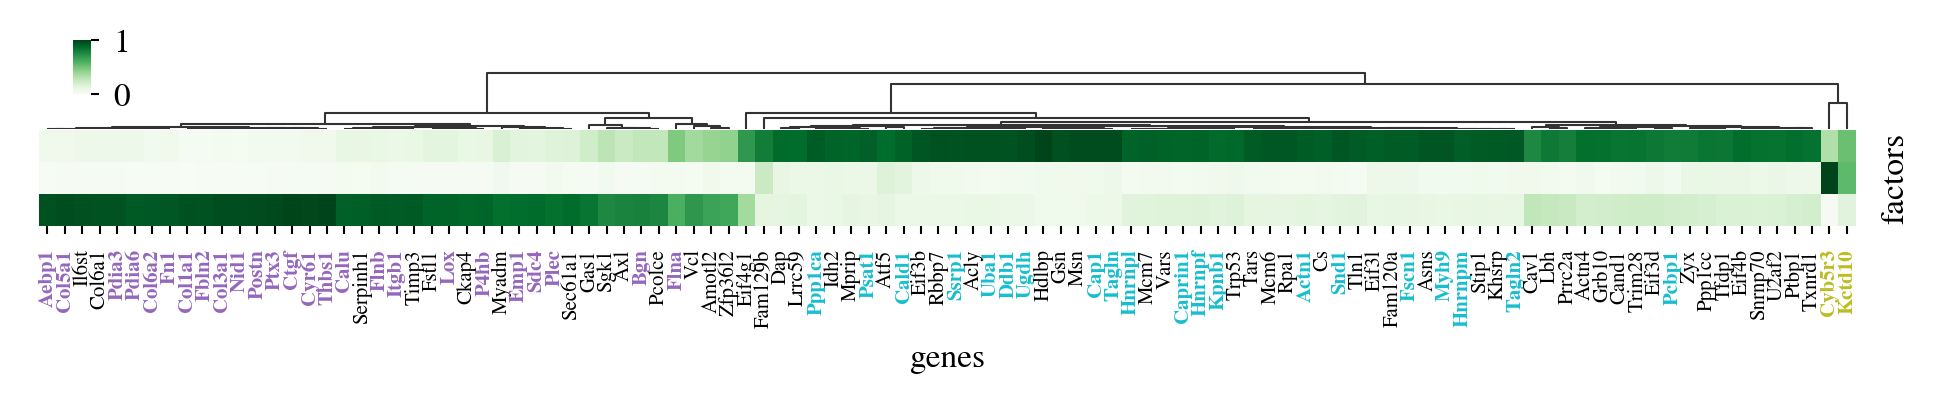

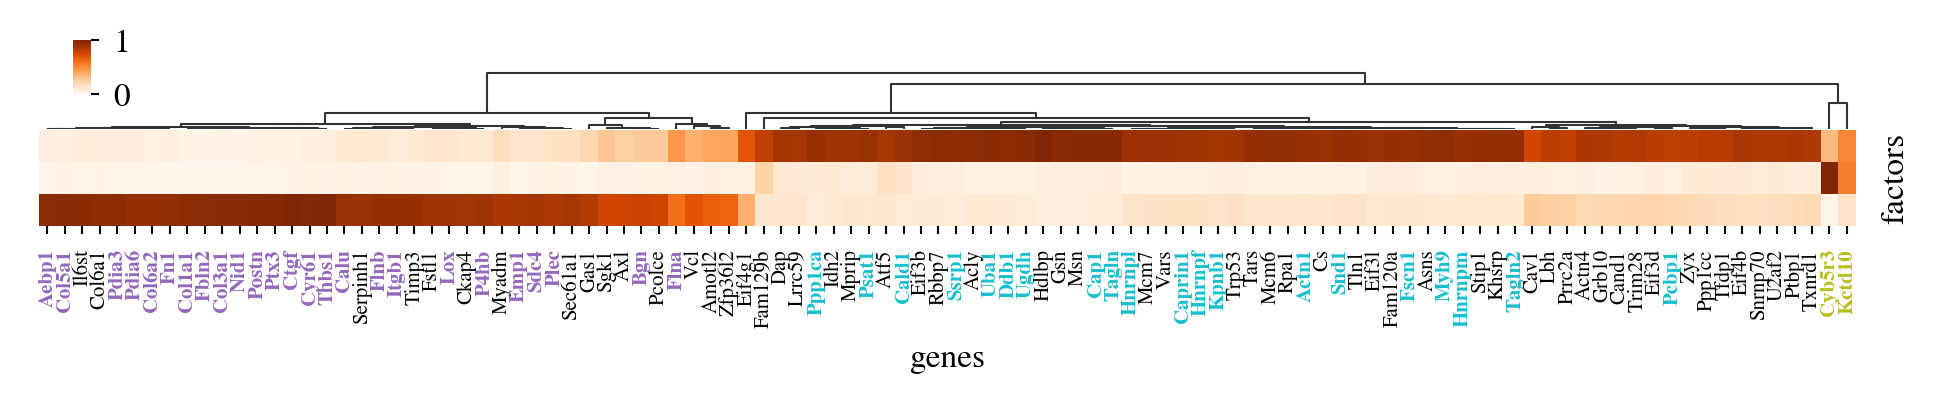

In [5]:
protrusion_genes = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1', 'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1', 'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nucleus_perinucleus_genes = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn', 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6', 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
nucleus_sc1_genes = ['Cyr61', 'Thbs1', 'Ctgf', 'Serpine1', 'Ptx3', 'Tnc']
nucleus_sc2_genes = ['Flna', 'Flnb', 'Plec', 'Flnc', 'lqgap1']
nucleus_sc3_genes = ['Bicd2', 'Nin', 'Pcnt', 'Numa1', 'Spdl1', 'Ctif', 'Cep350', 'Trip11', 'Gorasp2']
cytoplasm_genes = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1', 'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1', 'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

w = results['w']
w /= w.max(dim=0)[0].view(1, w.shape[1])

for cmap in ['Blues', 'Greens', 'Oranges']:
    im = sns.clustermap(w.numpy().T, figsize=(6.5, 1), row_cluster=False, cmap=cmap, dendrogram_ratio=(0,0.382))
    im.ax_cbar.set_box_aspect(3)
    im.ax_cbar.set_yticks([0, 1.])
    im.ax_heatmap.set_xlabel('genes')
    im.ax_heatmap.set_ylabel('factors')
    im.ax_heatmap.set_yticks([])
    im.ax_heatmap.set_xticks(torch.arange(w.shape[0]) + 0.5)

    inds = im.dendrogram_col.reordered_ind
    ordered_genes = other['genes'][inds]
    ordered_w = w[inds]
    im.ax_heatmap.set_xticklabels(ordered_genes, rotation='vertical', fontsize=5)

    for i, gene in enumerate(ordered_genes):
        if gene in protrusion_genes:
            im.ax_heatmap.get_xticklabels()[i].set_color('C8')
            im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')
        if gene in nucleus_perinucleus_genes + nucleus_sc1_genes + nucleus_sc2_genes + nucleus_sc3_genes:
            im.ax_heatmap.get_xticklabels()[i].set_color('C4')
            im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')
        if gene in cytoplasm_genes:
            im.ax_heatmap.get_xticklabels()[i].set_color('C9')
            im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')

    plt.savefig('plots/weights_{}.svg'.format(cmap))

## Bento signatures

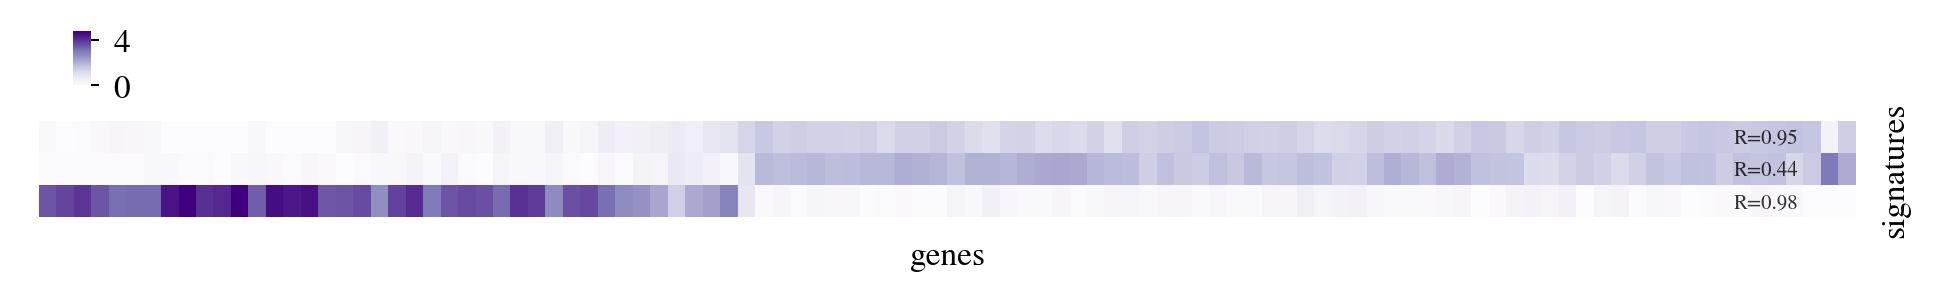

In [6]:
bento_signatures_df = pd.merge(pd.DataFrame({'gene' : ordered_genes}), bento_data.uns['tensor_loadings']['genes'], left_on='gene', right_index=True, how='left')
bento_signatures= bento_signatures_df.iloc[:, 1:].values

inds, _ = utils.optimal_assignment(ordered_w, torch.tensor(bento_signatures), 1)
bento_signatures = bento_signatures[:, inds]

corrs = []
for factor in range(3):
    corrs.append(round(pearsonr(ordered_w[:, factor].numpy(), bento_signatures[:, factor])[0], 2))

im = sns.clustermap(bento_signatures.T, figsize=(6.5, 1), row_cluster=False, col_cluster=False, cmap='Purples',  dendrogram_ratio=(0,0.382))
im.ax_cbar.set_box_aspect(3)
im.ax_cbar.set_yticks([0., 4.])
im.ax_heatmap.set_xlabel('genes')
im.ax_heatmap.set_ylabel('signatures')
for factor in range(3):
    im.ax_heatmap.text(x=97., y=0.7 + factor, s='R={}'.format(corrs[factor]), fontsize=5, alpha=0.8)
im.ax_heatmap.set_yticks([])
im.ax_heatmap.set_xticks([])

plt.savefig('plots/bento_signatures.svg')

## Clustering based on total counts

In [7]:
counts = pd.pivot(data.groupby(['gene', 'cell']).size().to_frame('count').reset_index(), index='gene', columns='cell').fillna(0)
transformed_counts = np.log(10000 * (counts / counts.sum(axis=0)) + 1)
transformed_counts_subset = transformed_counts[transformed_counts.index.isin(filtered_genes)]
nmf = NMF(n_components=3, init='nndsvd', max_iter=5000).fit(transformed_counts_subset.values.T)

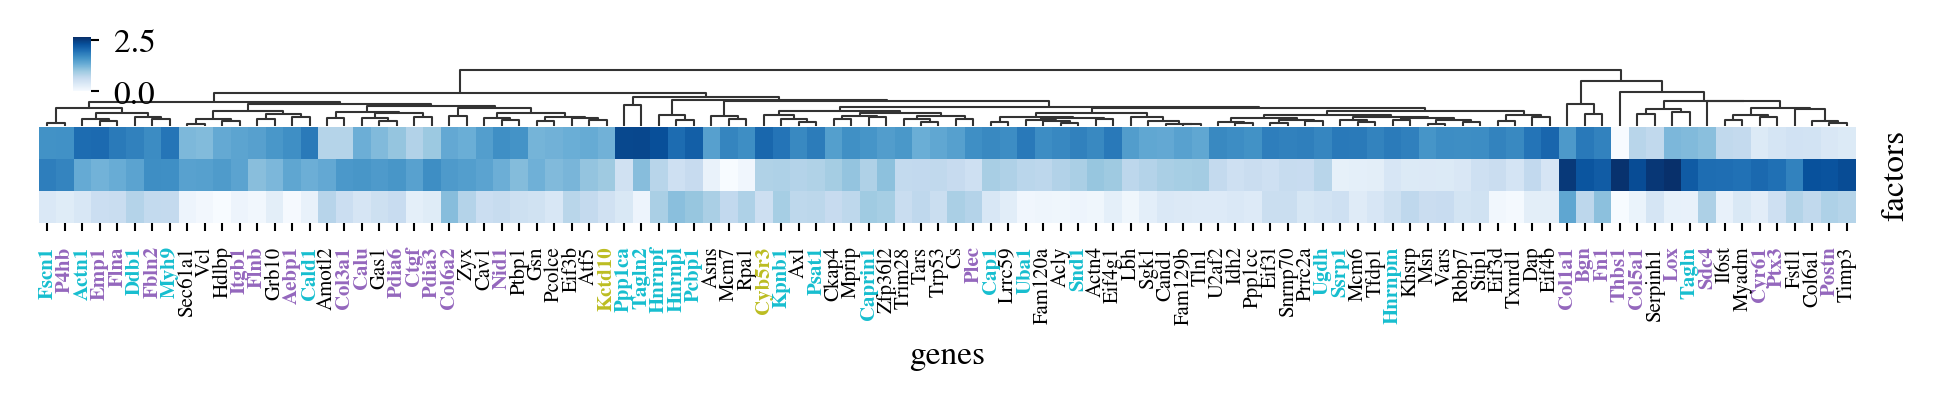

In [9]:
im = sns.clustermap(nmf.components_, figsize=(6.5, 1), row_cluster=False, cmap='Blues', dendrogram_ratio=(0,0.382))
im.ax_cbar.set_box_aspect(3)
im.ax_heatmap.set_xticks(np.arange(len(im.dendrogram_col.reordered_ind)) + 0.5)

cluster_inds = im.dendrogram_col.reordered_ind
ordered_genes = transformed_counts_subset.index[cluster_inds]
im.ax_heatmap.set_xticklabels(ordered_genes, rotation='vertical', fontsize=5)
im.ax_heatmap.set_yticks([])

for i, gene in enumerate(ordered_genes):
    if gene in protrusion_genes:
        im.ax_heatmap.get_xticklabels()[i].set_color('C8')
        im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')
    if gene in nucleus_perinucleus_genes + nucleus_sc1_genes + nucleus_sc2_genes + nucleus_sc3_genes:
        im.ax_heatmap.get_xticklabels()[i].set_color('C4')
        im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')
    if gene in cytoplasm_genes:
        im.ax_heatmap.get_xticklabels()[i].set_color('C9')
        im.ax_heatmap.get_xticklabels()[i].set_fontweight('bold')

im.ax_heatmap.set_xlabel('genes')
im.ax_heatmap.set_ylabel('factors')

plt.savefig('plots/counts_cluster.svg')